# 자동차 연비 예측하기: 회귀
- https://www.tensorflow.org/tutorials/keras/regression?hl=ko

In [1]:
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0-dev20201230


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# Downloads a file from a URL if it not already in the cache.
# the file at the url `origin` is downloaded to the cache_dir `~/.keras/datasets` and given the filename `fname` 
# (예: `~/.keras/datasets/example.txt`)

dataset_path

32768/30286 [================================] - 0s 5us/step


'/Users/wonji/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']

In [5]:
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

In [6]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
origin = dataset.pop('Origin')

In [12]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

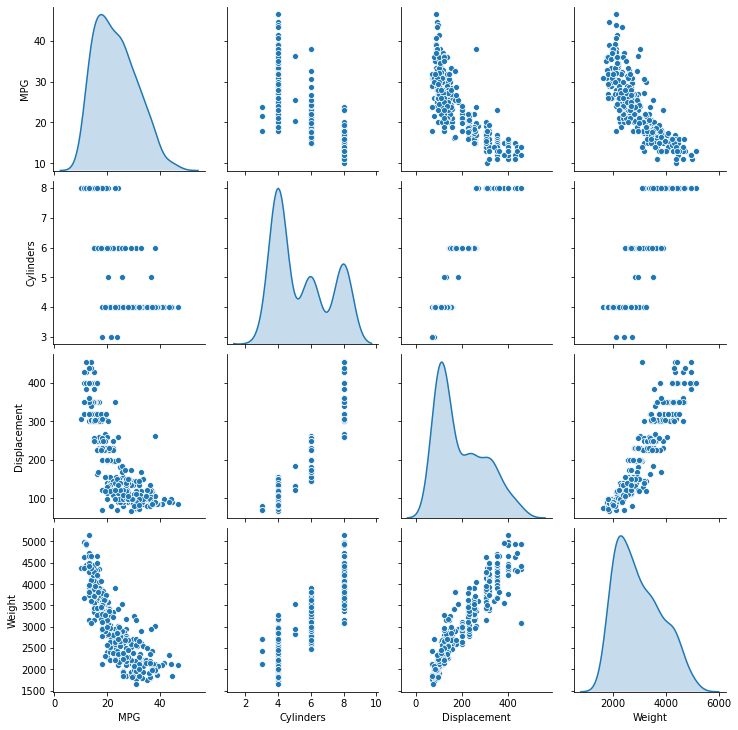

In [15]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [16]:
train_stats = train_dataset.describe()
train_stats.pop('MPG') # 정답지
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [17]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 
- 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

In [22]:
def norm(x):# 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서, train의 stat을 이용함 
    return (x - train_stats['mean'])/train_stats['std']

In [23]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [26]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), # 컬럼수가 tensor 크기?
        layers.Dense(64, activation='relu'),
        layers.Dense(1)        
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

In [28]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result # example의 regression 결과 

array([[ 0.2440266 ],
       [ 0.12745692],
       [-0.01017168],
       [ 0.12513694],
       [ 0.3625158 ],
       [ 0.2667755 ],
       [ 0.34581366],
       [-0.15260771],
       [ 0.16903523],
       [ 0.42289203]], dtype=float32)

In [32]:
class PrintDot(keras.callbacks.Callback): # callback: pass an argument to other code
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS,
    validation_split=0.2, 
    verbose=0, 
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.413970,0.977989,2.413970,9.195262,2.270266,9.195262,995
996,2.508225,0.990771,2.508225,9.009702,2.268245,9.009702,996
997,2.497809,1.024150,2.497809,8.681374,2.248901,8.681374,997
998,2.413764,0.967933,2.413764,8.896888,2.258703,8.896888,998
999,2.698076,1.071768,2.698076,9.207537,2.361021,9.207537,999


In [36]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('epochs')
    plt.ylabel('Mean abs error - MPG')
    plt.plot(hist['epoch'], hist['mae'], label='train error')
    plt.plot(hist['epoch'], hist['val_mae'], label='val error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('epochs')
    plt.ylabel('Mean square error - MPG squared')
    plt.plot(hist['epoch'], hist['mse'], label='train error')
    plt.plot(hist['epoch'], hist['val_mse'], label='val error')
    plt.ylim([0, 20])
    plt.legend()
    
    plt.show()

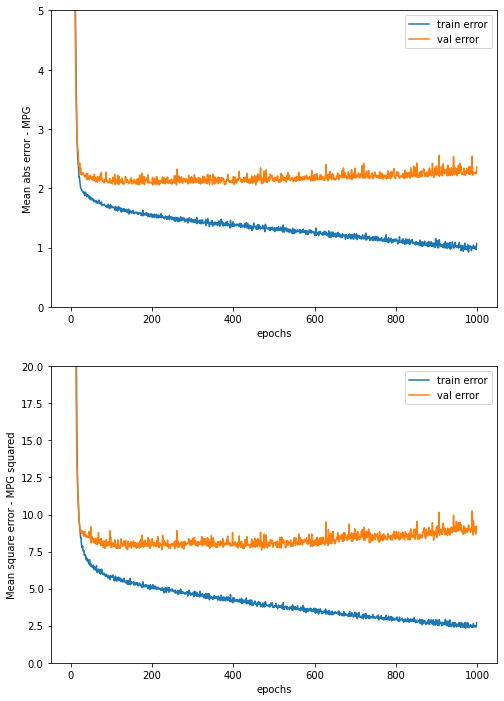

In [37]:
plot_history(history)

에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다. 
- 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.


...............................................

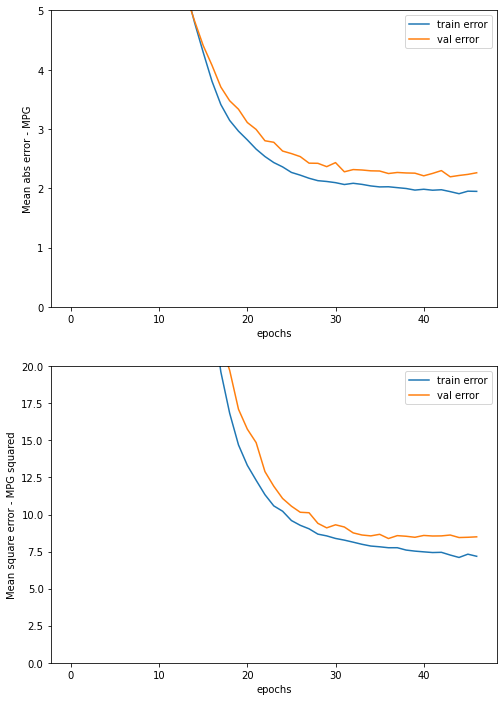

In [38]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
# print(loss, mae, mse)

3/3 - 0s - loss: 6.2034 - mae: 1.9083 - mse: 6.2034


In [45]:
test_predictions = model.predict(normed_test_data).flatten()
# array([[16.335949],
#        [11.140532], -> 1d array로 변환

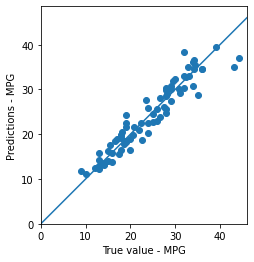

In [49]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True value - MPG')
plt.ylabel('Predictions - MPG')
plt.axis('equal') # axis 특성을 쉽게 하기 위함
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

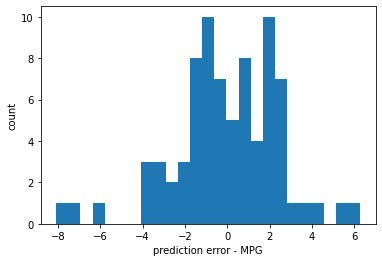

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("prediction error - MPG")
_ = plt.ylabel('count')

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

- 평균 제곱 오차(MSE): 회귀 문제에서 자주 사용하는 손실 함수
- 평균 절댓값 오차(MAE): 회귀에서 많이 사용하는 회귀 지표
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
- 훈련 데이터가 많지 않다면 -> 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
- 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.